# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Spatial join of Teranet points with Transportation Analysis Zones geometry

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 involves the spatial join of Teranet points with polygons of Transportation Analysis Zones (TAZ). It is performed to add new columns to each Teranet transaction from the TAZ in which it is located.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.


## Import dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import geopandas as gpd
import os
from shapely.geometry import Point
from time import time

In [2]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['Teranet_consistent.csv',
 'Teranet_with_DA_cols.csv',
 'Teranet_new_cols.csv',
 'Teranet_nonan_new_cols.csv',
 'HHSaleHistory.csv']

In [3]:
data_path = '../../data/'
taz_path = data_path + 'taz/TAZ_2001shp/'
os.listdir(taz_path)

['TAZ_2001.dbf',
 'TAZ_2001.sbn',
 'TAZ_2001.shp',
 'TAZ_2001.shx',
 'TAZ_2001.cpg',
 'TAZ_2001.prj',
 'TAZ_2001.sbx']

## Load geometry of Traffic Analysis Zones (TAZ)

----- GeoDataFrame loaded
in 0.27 seconds
with 1,716 rows
and 3 columns
-- Column names:
 Index(['OBJECTID', 'TAZ_O', 'geometry'], dtype='object')


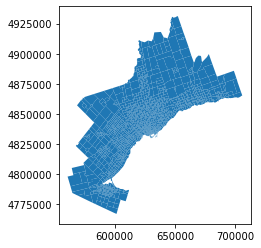

In [10]:
t = time()
taz_gdf = gpd.read_file(taz_path + 'TAZ_2001.shp')
elapsed = time() - t

cols = ['OBJECTID', 'TAZ_O', 'geometry']

taz_gdf = taz_gdf[cols]

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(taz_gdf.shape[0], taz_gdf.shape[1]) + 
      "\n-- Column names:\n", taz_gdf.columns)
      
taz_gdf.plot();

## Load Teranet data

In [11]:
t = time()
teranet_df = pd.read_csv(teranet_path + 'Teranet_DA_cols.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

t = time()
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_df['X'], teranet_df['Y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- DataFrame loaded
in 20.47 seconds
with 6,803,691 rows
and 18 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DA_OBJECTID', 'DAUID',
       'CSDNAME'],
      dtype='object')

----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 88.52 seconds (1.48 minutes)
with 6,803,691 rows
and 19 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DA_OBJECTID', 'DAUID',
       'CSDNAME', 'geometry'],
      dtype='object')

----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!


## Perform the spatial join of Teranet points with DA polygons
### Validate projections

In [12]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [13]:
taz_gdf.crs

{'init': 'epsg:26917'}

### Convert TAZ CRS to EPSG:4326

In [14]:
taz_gdf = taz_gdf.to_crs(epsg=4326)
taz_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

### Perform the spatial join

In [16]:
t = time()
teranet_taz_gdf = gpd.sjoin(teranet_gdf.to_crs(taz_gdf.crs), taz_gdf, 
                           how='left', op='within')
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_taz_gdf.shape[0], teranet_taz_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_taz_gdf.columns)


----- Spatial join completed, new GeoDataFrame created
in 843.52 seconds
with 6,803,756 rows
and 22 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DA_OBJECTID', 'DAUID',
       'CSDNAME', 'geometry', 'index_right', 'OBJECTID', 'TAZ_O'],
      dtype='object')


### Save results to a .csv file

In [18]:
save_path = teranet_path + 'Teranet_DA_TAZ_cols.csv'
t = time()
teranet_taz_gdf = teranet_taz_gdf.rename(columns={'OBJECTID':'TAZ_OBJECTID'})
teranet_taz_gdf.drop(['index_right', 'geometry'], axis=1).to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds".format(elapsed))

DataFrame saved to file:
 ../../data/teranet/Teranet_DA_TAZ_cols.csv 
took 134.69 seconds
